# Preprocesado para clasificación

##Integrantes

*   Juan Camilo Cataño Zuleta C.C 1001505918
*   Nataly Rodriguez Atehortua C.C 1001505918
*   Daniel Enrique López Yepes C.C 1000407016

##Descripción

En este Colab preprocesamos la información con el fin de aplicarla luego en los distintos modelos de clasificación. De igual forma en cada modelo de clasificación se corre esta misma rutina, por lo tanto puede ser idéntica o puede tener leves cambios como lo son la inclusión de un par de parámetros extra. 

## Ejecución de librerías y carga de datos

Lo primero es instalar las librerías que son necesarias para el proyecto

In [ ]:
#Instalo librerías que me van a ser útiles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from IPython.display import clear_output 

Lo siguiente es subir el aarchivo kaggle.json para poder descargar los archivos más adelante

In [ ]:
#Importamos los archivos de colab
from google.colab import files

#Subimos el .json
files.upload() #buscan el archivo kaggle.json en su ordenador

#Reubicamos el .json y descargamos el set de datos
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Ahora descargamos el set de datos

In [ ]:
#Se descarga el nuevo set de datos
!kaggle datasets download -d georgesaavedra/covid19-dataset

  0% 0.00/9.09M [00:00<?, ?B/s]
100% 9.09M/9.09M [00:00<00:00, 98.5MB/s]


Y lo descomprimimos

In [ ]:
#Se descomprime
!unzip /content/covid19-dataset.zip

Archive:  /content/covid19-dataset.zip
  inflating: owid-covid-data.csv     


Ahora cargo el csv

In [ ]:
dataset=pd.read_csv('owid-covid-data.csv') 

## Preprocesamiento y selección de valores

Lo primero será establecer cuáles son las columnas con las que se va a trabajar, estas serán:

*   **Nuevos casos** (new_cases): Se usará este parámetro con el fin de conocer cómo son los nuevos contagios en el país.
*   **Nuevas muertes** (new_deaths): Se usará este parámetro con el fin de conocer cómo es la tasa de mortalidad de la enfermedad.
*   **Admisiones en UCI semanales** (	weekly_icu_admissions): Se usará este parámetro con el fin de conocer cómo es la relación de pacientes en UCI.
*   **Población** (population): Se usará este parámetro con el fin de aterrizar los anteriores valores dado el contexto del país.



In [ ]:
#Ahora generamos el dataframe con la información que se necesita

#Primero elijo los datos que son obligatorios de reportar, estos serán el iso_code y la locación, es decir, el pais
cols_obligatory=["iso_code","continent","location"]

#Ahora elijo los datos con los que procesaré la información
cols_selected = ["new_cases","new_deaths","weekly_icu_admissions","population"]

#Ahora combino las columnas
cols=[]

for i in cols_obligatory:
  cols.append(i)

for i in cols_selected:
  cols.append(i)

#Ahora selecciono del dataset
myData=dataset.loc[:,cols]

#Ahora visualizo
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population
0,AFG,Asia,Afghanistan,5.0,NaN,NaN,39835428.0
1,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
2,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
3,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
4,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,NaN,15092171.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,NaN,15092171.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,NaN,15092171.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,NaN,15092171.0


Como se observa, falta información, por lo cual esta será llenada por ceros, pues se asumirá que ese día el registro no pudo ser tomado o aún no estaba siendo rastreado.

In [ ]:
#Relleno la información de ceros
myData=myData.fillna(0)

#Ahora visualizo la información
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population
0,AFG,Asia,Afghanistan,5.0,0.0,0.0,39835428.0
1,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
2,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
3,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
4,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,0.0,15092171.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,0.0,15092171.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,0.0,15092171.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,0.0,15092171.0


Ahora lo siguiente es la construcción de variables auxiliares de clasificación, estas variables son:

---


**Porcentaje de nuevos casos**

Esta variable indica cuánto es el porcentaje de nuevos casos en relación a la población total.

Matemáticamente está definida como:
```
(Nuevos casos / Población)*100*1000
```

La clasificación de riesgo se hará bajo 3 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 20%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población que ha sido infectada. Se aplica una extrapolación debido a que se espera que sea un valor muy pequeño, es por ello que el porcentaje se eleva 1000 veces más.

---

**Porcentaje de mortalidad**

Esta variable indica cuánto es el porcentaje de nuevas muertes en base a los nuevos contagios.

Matemáticamente está definida como:
```
(Nuevas muertes / Nuevos casos)*100
```

La clasificación de riesgo se hará bajo 3 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 10%.
*   **Riesgo moderado**: Si el valor está por encima del 3%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 3%.

Este parámetro indica cuánto es el porcentaje de la población infectada que ha muerto.

---

**Porcentaje de UCI**

Esta variable indica cuánto es el porcentaje de pacientes en UCI en relación a los nuevos casos registrados.

Matemáticamente está definida como:
```
(Admisiones de UCI semanales / Nuevos casos)*100
```

La clasificación de riesgo se hará bajo 3 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 15%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población infectada recientemente y cómo es el comportamiento de los hospitalizados en UCI.


**Peso de los parámetros:**

El nivel de clasificación general también será basado en 3 niveles, donde a mayor nivel es mayor el riesgo. Los anteriores valores tienen cierto peso para establecer el nivel de peligro. La ponderación es la siguiente:

1.   **Porcentaje de casos:** 33.3%
4.   **Porcentaje de UCI:** 33.3%
5.   **Porcentaje de mortalidad:** 33.3%


Ahora entonces se construye el dataset de procesamiento

In [ ]:
#Genero el dataset de procesamiento
myProcess=pd.DataFrame()

#Ahora realizo los cálculos
myProcess["Infection_percent"]=(myData["new_cases"]/myData["population"])*100000
myProcess["Mortality_percent"]=(myData["new_deaths"]/myData["new_cases"])*100
myProcess["UCI_percent"]=(myData["weekly_icu_admissions"]/myData["new_cases"])*100
#Relleno la información de la que no tengo valores
myProcess=myProcess.fillna(0)

#Observo
myProcess

,Infection_percent,Mortality_percent,UCI_percent
0,0.012552,0.000000,0.0
1,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0
...,...,...,...
166321,3.253342,0.000000,0.0
166322,4.187602,0.158228,0.0
166323,0.000000,0.000000,0.0
166324,8.189677,0.080906,0.0


Lo siguiente entonces es rankear esta información según lo que necesito

In [ ]:
#Porcentaje de contagios
mycol=pd.DataFrame()

#Obtengo la columna
mycol["Infection_percent"]=myProcess["Infection_percent"].copy()

#Ahora rankeo según el valor
mycol["Infection_percent"][mycol["Infection_percent"]<=5]=1
mycol[(mycol["Infection_percent"]<=20)&(mycol["Infection_percent"]>5)]=2
mycol[mycol["Infection_percent"]>20]=3

#Porcentaje de mortalidad

#Obtengo la columna
mycol["Mortality_percent"]=myProcess["Mortality_percent"]

#Ahora rankeo según el valor
mycol[mycol["Mortality_percent"]<=3]=1
mycol[(mycol["Mortality_percent"]<=10)&(mycol["Mortality_percent"]>3)]=2
mycol[mycol["Mortality_percent"]>10]=3

#Porcentaje de UCI

#Obtengo la columna
mycol["UCI_percent"]=myProcess["UCI_percent"]

#Ahora rankeo según el valor
mycol[mycol["UCI_percent"]<=5]=1
mycol[(mycol["UCI_percent"]<=15)&(mycol["UCI_percent"]>5)]=2
mycol[mycol["UCI_percent"]>15]=3

#Ahora visualizo de nuevo la tabla
mycol


,Infection_percent,Mortality_percent,UCI_percent
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
...,...,...,...
166321,1.0,1.0,1.0
166322,1.0,1.0,1.0
166323,1.0,1.0,1.0
166324,1.0,1.0,1.0


In [ ]:
#Visualizo la distribución de casos en general
print("Infection_percent")
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==1]))
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==2]))
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==3]))
print("\nMortality_percent")
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==1]))
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==2]))
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==3]))
print("\nUCI_percent")
print(len(mycol["UCI_percent"][mycol["UCI_percent"]==1]))
print(len(mycol["UCI_percent"][mycol["UCI_percent"]==2]))
print(len(mycol["UCI_percent"][mycol["UCI_percent"]==3]))

Infection_percent
163313
1728
1285

Mortality_percent
163313
1728
1285

UCI_percent
163313
1728
1285


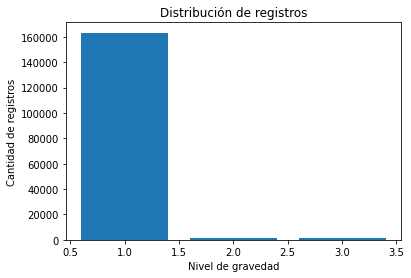

In [ ]:
#Ploteo los casos de nuevos contagios
plt.bar([1,2,3],[len(mycol["Infection_percent"][mycol["Infection_percent"]==1]),len(mycol["Infection_percent"][mycol["Infection_percent"]==2]),len(mycol["Infection_percent"][mycol["Infection_percent"]==3])])
plt.xlabel("Nivel de gravedad")
plt.ylabel("Cantidad de registros")
plt.title("Distribución de registros")

plt.show()

Ahora queda generar la nueva variable, la cual será la ponderación de estos valores



In [ ]:
#Aplico la operación
mycol["Result"]=round(mycol["Infection_percent"]*0.33+mycol["Mortality_percent"]*0.33+mycol["UCI_percent"]*0.33,0)

#Ahora visualizo
mycol

,Infection_percent,Mortality_percent,UCI_percent,Result
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
...,...,...,...,...
166321,1.0,1.0,1.0,1.0
166322,1.0,1.0,1.0,1.0
166323,1.0,1.0,1.0,1.0
166324,1.0,1.0,1.0,1.0


In [ ]:
print("\nResult")
print(len(mycol[mycol["Result"]==1]))
print(len(mycol[mycol["Result"]==2]))
print(len(mycol[mycol["Result"]==3]))


Result
163313
1728
1285


Con la información obtenida entonces añado esta columna al dataset principal

In [ ]:
#Añado la columna
myData["clasification"]=mycol["Result"]

#Visualizo
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population,clasification
0,AFG,Asia,Afghanistan,5.0,0.0,0.0,39835428.0,1.0
1,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
2,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
3,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
4,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
...,...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,0.0,15092171.0,1.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,0.0,15092171.0,1.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,0.0,15092171.0,1.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,0.0,15092171.0,1.0


## Construcción del set de entrenamiento y prueba

Debido al gran volumen de datos, el set se va a dividir en 3 partes, de la siguiente forma:

*   **Set de entrenamiento:** 70%
*   **Set de prueba:** 30%

Estos valores serán separados aleatoriamente por software, de esta forma se busca eliminar posibles problemas como el sesgo.

Voy a analizar el set de argentina

In [ ]:
#Obtengo el dataset de Argentina
mySet=myData[myData["location"]=="Argentina"]

#Observo los resultados
print("\nResult")
print(len(mySet[mySet["clasification"]==1]))
print(len(mySet[mySet["clasification"]==2]))
print(len(mySet[mySet["clasification"]==3]))


Result
795
0
0


Como se observa, Argentina no llegó a los niveles críticos, por lo cual es necesario tomar datos de países aleatorios para poder realizar el entrenamiento. Se van a tomar 500 datos de cada tipo, es decir, 500 con clasificación de 1, 500 con clasificación de 2 y 500 con clasificación de 3.

In [ ]:
#Tomo muestras aleatorias
clas_1=myData[myData["clasification"]==1].sample(500)
clas_2=myData[myData["clasification"]==2].sample(500)
clas_3=myData[myData["clasification"]==3].sample(500)

#Añado todo
mySet=pd.concat([clas_1,clas_2,clas_3])

#Lo revuelvo completamente
mySet=mySet.sample(frac = 1)

#Visualizo
mySet

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population,clasification
54283,FRA,Europe,France,8536.0,385.0,3467.0,67422000.0,3.0
39129,CZE,Europe,Czechia,295.0,11.0,38.0,10724553.0,2.0
59758,GRC,Europe,Greece,103.0,1.0,13.0,10370747.0,2.0
39547,CZE,Europe,Czechia,113.0,4.0,45.0,10724553.0,3.0
27508,CAN,North America,Canada,3940.0,116.0,0.0,38067913.0,1.0
...,...,...,...,...,...,...,...,...
39364,CZE,Europe,Czechia,1074.0,84.0,283.0,10724553.0,3.0
141398,ESP,Europe,Spain,11731.0,95.0,1068.0,46745211.0,2.0
141267,ESP,Europe,Spain,0.0,0.0,620.0,46745211.0,3.0
59765,GRC,Europe,Greece,94.0,2.0,42.0,10370747.0,3.0


Ahora sí entreno los valores

In [ ]:
#Obtengo los valores que se ingresan
x=mySet.loc[:,["new_cases","new_deaths","weekly_icu_admissions","population"]].values

#Obtengo los resultados
y=mySet["clasification"]

In [ ]:
#Verifico las formas
print(x.shape)
print(y.shape)

(1500, 4)
(1500,)


In [ ]:
#Verifico que no haya datos nulos
print(np.any(np.isnan(x)),np.any(np.isnan(y)))

False False


In [ ]:
#Verifico que todos los datos sean finitos
print(np.all(np.isfinite(x)),np.all(np.isfinite(y)))

True True
